In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import deque
from collections import namedtuple
import typing

/home/jdufou1/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class QNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations, 125),
            nn.ReLU(),
            nn.Linear(125,100),
            nn.ReLU(),
            nn.Linear(100, nb_actions)
        )
        
    def forward(self,x) :
        return self.net(x)

class DuelingQNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32)
        )
        
        self.net_advantage = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,nb_actions)
        )
        
        self.net_state_value = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,1)
        )
        
    def advantage(self,x) :
        return self.net_advantage(self.net(x))
    
    def state_value(self,x) :
        return self.net_state_value(self.net(x))
    
    def forward(self,x) :
        return self.state_value(x) + self.advantage(x) - torch.mean(self.advantage(x),dim=1).unsqueeze(1)

In [3]:
"""
Prioritized Experience Replay
"""


_field_names = [
    "state",
    "action",
    "reward",
    "done",
    "new_state"
    
]
Experience = namedtuple("Experience", field_names=_field_names)

class PrioritizedExperienceReplayBuffer:
    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return self._buffer_length

    def alpha(self):
        return self._alpha

    def batch_size(self) -> int:
        return self._batch_size
    
    def buffer_size(self) -> int:
        return self._buffer_size

    def add(self, experience: Experience) -> None:
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        experiences = self._buffer["experience"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        self._buffer["priority"][idxs] = priorities
        

def exponential_annealing_schedule(episode, rate=1e-2):
    return 1 - np.exp(-rate * episode)

In [4]:
def test(q_network) :
    state = env.reset()
    done = False
    cum_sum = 0
    timestep = 0
    while not done  :
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        timestep +=1
        
    return cum_sum

In [5]:
env = gym.make("CartPole-v0")
nb_actions = 2
nb_observations = 4

## vanilla DQN

In [6]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
update_frequency = 1

In [7]:

average_list = deque(maxlen=100)

q_network = QNetwork(nb_actions,nb_observations)
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_1 = []
timestep = 0
for episode in tqdm(range(nb_episode)) :
    
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    state = env.reset()
    done = False
    cumul = 0
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        if timestep % update_frequency == 0:

            done_t = torch.as_tensor(done , dtype = torch.int64)
            new_state_t = torch.as_tensor(new_state , dtype=torch.float32)
            action_t = torch.as_tensor(action , dtype = torch.int64)

            y_target = reward + discount_factor * (1 - done_t) * torch.max(q_network(new_state_t))

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(state_t),dim=0,index=action_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = new_state
        timestep += 1
    
    average_list.append(cumul)
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_1.append(t)

  1%|▎                                         | 7/1000 [00:00<00:28, 35.20it/s]

episode 0 - test reward : 14.6 - avg : 13.0 - epsilon 0.995


  2%|▋                                        | 17/1000 [00:00<00:22, 43.61it/s]

episode 10 - test reward : 9.4 - avg : 19.545454545454547 - epsilon 0.946354579813443


  3%|█▏                                       | 28/1000 [00:00<00:22, 43.25it/s]

episode 20 - test reward : 9.4 - avg : 19.666666666666668 - epsilon 0.9000874278732445


  4%|█▋                                       | 40/1000 [00:00<00:22, 43.21it/s]

episode 30 - test reward : 9.6 - avg : 18.806451612903224 - epsilon 0.8560822709551227


  4%|█▊                                       | 45/1000 [00:01<00:23, 41.25it/s]

episode 40 - test reward : 9.1 - avg : 18.951219512195124 - epsilon 0.8142285204175609


  6%|██▎                                      | 55/1000 [00:01<00:24, 38.66it/s]

episode 50 - test reward : 10.8 - avg : 19.607843137254903 - epsilon 0.7744209942832988


  6%|██▌                                      | 64/1000 [00:01<00:30, 31.06it/s]

episode 60 - test reward : 15.7 - avg : 20.80327868852459 - epsilon 0.736559652908221


  8%|███                                      | 76/1000 [00:02<00:29, 31.62it/s]

episode 70 - test reward : 13.3 - avg : 20.760563380281692 - epsilon 0.7005493475733617


  9%|███▋                                     | 90/1000 [00:02<00:22, 39.74it/s]

episode 80 - test reward : 21.7 - avg : 21.185185185185187 - epsilon 0.6662995813682115
episode 90 - test reward : 9.6 - avg : 20.373626373626372 - epsilon 0.6337242817644086


 10%|████                                    | 103/1000 [00:02<00:28, 31.68it/s]

episode 100 - test reward : 9.4 - avg : 20.97 - epsilon 0.6027415843082742


 12%|████▋                                   | 117/1000 [00:03<00:26, 33.60it/s]

episode 110 - test reward : 9.5 - avg : 21.01 - epsilon 0.5732736268885887


 12%|█████                                   | 125/1000 [00:03<00:32, 27.24it/s]

episode 120 - test reward : 25.9 - avg : 21.4 - epsilon 0.5452463540625918


 13%|█████▎                                  | 134/1000 [00:03<00:25, 33.31it/s]

episode 130 - test reward : 14.9 - avg : 22.27 - epsilon 0.5185893309484582


 14%|█████▋                                  | 143/1000 [00:04<00:29, 28.73it/s]

episode 140 - test reward : 9.2 - avg : 22.75 - epsilon 0.4932355662165453


 16%|██████▏                                 | 155/1000 [00:04<00:23, 35.75it/s]

episode 150 - test reward : 9.6 - avg : 22.36 - epsilon 0.46912134373457726


 16%|██████▌                                 | 164/1000 [00:04<00:25, 32.27it/s]

episode 160 - test reward : 23.2 - avg : 21.62 - epsilon 0.446186062443672


 17%|██████▉                                 | 174/1000 [00:05<00:35, 23.21it/s]

episode 170 - test reward : 14.3 - avg : 23.43 - epsilon 0.42437208406280985


 19%|███████▌                                | 189/1000 [00:05<00:28, 28.91it/s]

episode 180 - test reward : 10.1 - avg : 24.05 - epsilon 0.4036245882390106


 20%|███████▉                                | 199/1000 [00:06<00:23, 34.72it/s]

episode 190 - test reward : 15.0 - avg : 24.05 - epsilon 0.38389143477919885


 20%|████████                                | 203/1000 [00:06<00:28, 28.33it/s]

episode 200 - test reward : 18.7 - avg : 23.19 - epsilon 0.36512303261753626


 22%|████████▋                               | 216/1000 [00:06<00:23, 32.91it/s]

episode 210 - test reward : 16.2 - avg : 24.28 - epsilon 0.3472722151889232


 23%|█████████▏                              | 231/1000 [00:07<00:20, 37.78it/s]

episode 220 - test reward : 16.5 - avg : 24.3 - epsilon 0.3302941218954743
episode 230 - test reward : 12.5 - avg : 22.93 - epsilon 0.3141460853680822


 24%|█████████▊                              | 245/1000 [00:07<00:24, 30.35it/s]

episode 240 - test reward : 21.1 - avg : 22.91 - epsilon 0.2987875242397482


 26%|██████████▏                             | 256/1000 [00:07<00:19, 38.75it/s]

episode 250 - test reward : 11.9 - avg : 22.95 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [00:08<00:27, 26.98it/s]

episode 260 - test reward : 65.3 - avg : 23.79 - epsilon 0.2702863258025825


 27%|██████████▉                             | 274/1000 [00:09<00:37, 19.12it/s]

episode 270 - test reward : 75.4 - avg : 24.24 - epsilon 0.2570720625972084


 28%|███████████▎                            | 283/1000 [00:09<00:28, 25.01it/s]

episode 280 - test reward : 11.4 - avg : 24.34 - epsilon 0.24450384299593592


 30%|███████████▊                            | 296/1000 [00:09<00:27, 25.70it/s]

episode 290 - test reward : 13.8 - avg : 25.8 - epsilon 0.23255008201124722


 30%|████████████                            | 302/1000 [00:10<00:41, 16.98it/s]

episode 300 - test reward : 77.6 - avg : 28.21 - epsilon 0.2211807388415433


 31%|████████████▌                           | 314/1000 [00:11<00:40, 17.03it/s]

episode 310 - test reward : 40.0 - avg : 29.33 - epsilon 0.21036724137609603


 32%|████████████▉                           | 324/1000 [00:11<00:35, 18.84it/s]

episode 320 - test reward : 29.8 - avg : 31.01 - epsilon 0.2000824143909432


 34%|█████████████▍                          | 335/1000 [00:11<00:21, 30.99it/s]

episode 330 - test reward : 12.4 - avg : 31.65 - epsilon 0.1903004112552766


 35%|█████████████▉                          | 349/1000 [00:12<00:20, 31.23it/s]

episode 340 - test reward : 32.6 - avg : 31.94 - epsilon 0.18099664897669618


 35%|██████████████                          | 353/1000 [00:12<00:29, 21.77it/s]

episode 350 - test reward : 108.8 - avg : 32.58 - epsilon 0.17214774642209296


 37%|██████████████▊                         | 370/1000 [00:13<00:16, 37.14it/s]

episode 360 - test reward : 9.8 - avg : 32.16 - epsilon 0.16373146555890544
episode 370 - test reward : 9.4 - avg : 28.8 - epsilon 0.1557266555690826


 38%|███████████████▎                        | 382/1000 [00:13<00:28, 21.68it/s]

episode 380 - test reward : 34.7 - avg : 29.29 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 393/1000 [00:14<00:36, 16.44it/s]

episode 390 - test reward : 52.9 - avg : 31.52 - epsilon 0.14087196468590776


 40%|████████████████                        | 403/1000 [00:14<00:26, 22.28it/s]

episode 400 - test reward : 9.4 - avg : 31.35 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 412/1000 [00:15<00:31, 18.62it/s]

episode 410 - test reward : 47.1 - avg : 30.47 - epsilon 0.12743425563174798


 43%|█████████████████                       | 428/1000 [00:15<00:19, 29.59it/s]

episode 420 - test reward : 10.4 - avg : 29.8 - epsilon 0.12120401149972035


 43%|█████████████████▎                      | 433/1000 [00:16<00:22, 24.66it/s]

episode 430 - test reward : 25.0 - avg : 29.29 - epsilon 0.11527836319047392


 44%|█████████████████▌                      | 440/1000 [00:16<00:17, 31.94it/s]

episode 440 - test reward : 27.6 - avg : 28.91 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [00:17<00:44, 12.26it/s]

episode 450 - test reward : 84.3 - avg : 34.93 - epsilon 0.1042820154910064


 46%|██████████████████▌                     | 463/1000 [00:18<00:49, 10.80it/s]

episode 460 - test reward : 71.2 - avg : 39.86 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [00:19<00:54,  9.69it/s]

episode 470 - test reward : 70.6 - avg : 44.55 - epsilon 0.0943346041173244


 48%|███████████████████▎                    | 483/1000 [00:20<00:44, 11.70it/s]

episode 480 - test reward : 60.0 - avg : 45.55 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 493/1000 [00:21<00:38, 13.33it/s]

episode 490 - test reward : 44.1 - avg : 46.18 - epsilon 0.08533607153708872


 50%|████████████████████▏                   | 505/1000 [00:22<00:28, 17.34it/s]

episode 500 - test reward : 10.1 - avg : 48.13 - epsilon 0.0811640021330769
episode 510 - test reward : 16.5 - avg : 46.06 - epsilon 0.07719590465791494


 52%|█████████████████████                   | 525/1000 [00:22<00:11, 40.31it/s]

episode 520 - test reward : 10.9 - avg : 43.88 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 530/1000 [00:22<00:15, 30.57it/s]

episode 530 - test reward : 67.3 - avg : 45.58 - epsilon 0.06983222438783


 55%|█████████████████████▉                  | 549/1000 [00:24<00:24, 18.44it/s]

episode 540 - test reward : 23.4 - avg : 51.89 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 552/1000 [00:24<00:33, 13.53it/s]

episode 550 - test reward : 59.8 - avg : 45.79 - epsilon 0.06317096204211972


 57%|██████████████████████▋                 | 566/1000 [00:25<00:19, 21.93it/s]

episode 560 - test reward : 15.4 - avg : 41.25 - epsilon 0.06008254194952879


 57%|██████████████████████▉                 | 572/1000 [00:26<00:41, 10.43it/s]

episode 570 - test reward : 199.8 - avg : 40.43 - epsilon 0.05714511431233153


 59%|███████████████████████▌                | 590/1000 [00:26<00:18, 22.55it/s]

episode 580 - test reward : 11.3 - avg : 39.98 - epsilon 0.0543512971290831
episode 590 - test reward : 11.5 - avg : 35.37 - epsilon 0.05169406930342616


 60%|███████████████████████▉                | 599/1000 [00:27<00:16, 24.76it/s]

episode 600 - test reward : 70.6 - avg : 32.73 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 612/1000 [00:28<00:32, 12.05it/s]

episode 610 - test reward : 15.3 - avg : 40.25 - epsilon 0.04676299685992172


 62%|████████████████████████▉               | 624/1000 [00:29<00:28, 12.98it/s]

episode 620 - test reward : 16.9 - avg : 47.23 - epsilon 0.04447676004441063


 64%|█████████████████████████▌              | 639/1000 [00:30<00:17, 20.19it/s]

episode 630 - test reward : 81.3 - avg : 50.77 - epsilon 0.04230229704853423
episode 640 - test reward : 12.9 - avg : 43.36 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 653/1000 [00:31<00:12, 28.58it/s]

episode 650 - test reward : 9.4 - avg : 43.74 - epsilon 0.03826710124979409


 66%|██████████████████████████▌             | 665/1000 [00:31<00:12, 26.64it/s]

episode 660 - test reward : 72.5 - avg : 42.95 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 674/1000 [00:32<00:14, 22.23it/s]

episode 670 - test reward : 50.6 - avg : 41.32 - epsilon 0.03461682084029365


 69%|███████████████████████████▌            | 690/1000 [00:32<00:07, 39.92it/s]

episode 680 - test reward : 11.8 - avg : 39.59 - epsilon 0.032924408985721944
episode 690 - test reward : 12.0 - avg : 39.66 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 700/1000 [00:32<00:08, 34.57it/s]

episode 700 - test reward : 178.4 - avg : 39.15 - epsilon 0.029783765425331846


 72%|████████████████████████████▋           | 716/1000 [00:33<00:10, 27.59it/s]

episode 710 - test reward : 9.2 - avg : 32.74 - epsilon 0.02832764101944931


 73%|█████████████████████████████▎          | 732/1000 [00:34<00:08, 32.02it/s]

episode 720 - test reward : 11.4 - avg : 28.45 - epsilon 0.02694270634579598
episode 730 - test reward : 11.3 - avg : 23.08 - epsilon 0.02562548094765099


 75%|█████████████████████████████▉          | 749/1000 [00:34<00:09, 26.62it/s]

episode 740 - test reward : 62.8 - avg : 26.72 - epsilon 0.02437265452736848
episode 750 - test reward : 10.1 - avg : 24.98 - epsilon 0.023181078627322618


 77%|██████████████████████████████▊         | 771/1000 [00:35<00:04, 47.39it/s]

episode 760 - test reward : 9.7 - avg : 24.01 - epsilon 0.022047758717570132
episode 770 - test reward : 9.6 - avg : 21.79 - epsilon 0.020969846670345987


 79%|███████████████████████████████▋        | 793/1000 [00:35<00:03, 59.91it/s]

episode 780 - test reward : 9.7 - avg : 20.29 - epsilon 0.02
episode 790 - test reward : 9.8 - avg : 20.11 - epsilon 0.02


 81%|████████████████████████████████▌       | 814/1000 [00:35<00:02, 64.63it/s]

episode 800 - test reward : 9.5 - avg : 18.34 - epsilon 0.02
episode 810 - test reward : 9.7 - avg : 16.89 - epsilon 0.02


 83%|█████████████████████████████████▏      | 829/1000 [00:36<00:02, 66.32it/s]

episode 820 - test reward : 9.6 - avg : 13.95 - epsilon 0.02
episode 830 - test reward : 9.1 - avg : 13.7 - epsilon 0.02


 85%|██████████████████████████████████      | 852/1000 [00:36<00:02, 69.41it/s]

episode 840 - test reward : 9.5 - avg : 9.77 - epsilon 0.02
episode 850 - test reward : 8.9 - avg : 9.59 - epsilon 0.02


 87%|██████████████████████████████████▉     | 873/1000 [00:36<00:01, 68.11it/s]

episode 860 - test reward : 10.3 - avg : 9.62 - epsilon 0.02
episode 870 - test reward : 9.5 - avg : 9.61 - epsilon 0.02


 89%|███████████████████████████████████▌    | 889/1000 [00:36<00:01, 71.80it/s]

episode 880 - test reward : 10.1 - avg : 9.59 - epsilon 0.02
episode 890 - test reward : 9.1 - avg : 9.52 - epsilon 0.02


 90%|███████████████████████████████████▉    | 897/1000 [00:37<00:01, 72.77it/s]

episode 900 - test reward : 10.6 - avg : 9.53 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [00:38<00:07, 12.71it/s]

episode 910 - test reward : 200.0 - avg : 21.24 - epsilon 0.02


 92%|████████████████████████████████████▊   | 919/1000 [00:40<00:10,  7.62it/s]

episode 920 - test reward : 200.0 - avg : 38.17 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [00:43<00:14,  4.62it/s]

episode 930 - test reward : 173.1 - avg : 52.74 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 942/1000 [00:45<00:09,  6.13it/s]

episode 940 - test reward : 100.5 - avg : 63.51 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [00:47<00:13,  3.64it/s]

episode 950 - test reward : 200.0 - avg : 75.44 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 960/1000 [00:48<00:04,  9.43it/s]

episode 960 - test reward : 200.0 - avg : 83.67 - epsilon 0.02


 97%|██████████████████████████████████████▉ | 972/1000 [00:51<00:06,  4.59it/s]

episode 970 - test reward : 137.1 - avg : 98.43 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [00:53<00:06,  3.10it/s]

episode 980 - test reward : 200.0 - avg : 117.08 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [00:54<00:01,  8.52it/s]

episode 990 - test reward : 112.7 - avg : 124.24 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.46it/s]


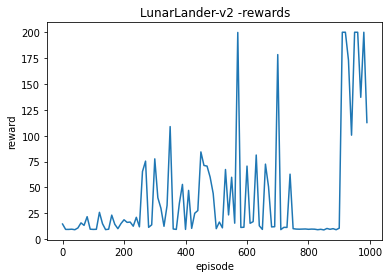

In [8]:
plt.figure()
plt.title("LunarLander-v2 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_1)
plt.show()

## DQN with Experience Replay Buffer

In [9]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = 10000
update_frequency = 1

In [10]:


replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)

timestep = 0

optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_2 = []

average_list = deque(maxlen=100)
for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        
        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_network(new_states_t),dim=1)[0]

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = new_state
        timestep += 1
    
    average_list.append(cumul)
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_2.append(t)

  0%|▏                                         | 5/1000 [00:00<00:25, 38.99it/s]

episode 0 - test reward : 9.9 - avg : 31.0 - epsilon 0.995


  2%|▌                                        | 15/1000 [00:00<00:42, 23.06it/s]

episode 10 - test reward : 30.5 - avg : 25.09090909090909 - epsilon 0.946354579813443


  2%|▉                                        | 24/1000 [00:00<00:37, 25.95it/s]

episode 20 - test reward : 21.0 - avg : 22.428571428571427 - epsilon 0.9000874278732445


  3%|█▍                                       | 34/1000 [00:01<00:41, 23.27it/s]

episode 30 - test reward : 13.0 - avg : 21.64516129032258 - epsilon 0.8560822709551227


  5%|█▉                                       | 46/1000 [00:01<00:43, 21.68it/s]

episode 40 - test reward : 9.9 - avg : 22.829268292682926 - epsilon 0.8142285204175609


  5%|██▏                                      | 54/1000 [00:02<00:46, 20.51it/s]

episode 50 - test reward : 10.4 - avg : 23.372549019607842 - epsilon 0.7744209942832988


  6%|██▋                                      | 65/1000 [00:02<00:46, 19.93it/s]

episode 60 - test reward : 9.3 - avg : 23.639344262295083 - epsilon 0.736559652908221


  8%|███                                      | 75/1000 [00:03<00:45, 20.44it/s]

episode 70 - test reward : 16.4 - avg : 23.47887323943662 - epsilon 0.7005493475733617


  8%|███▍                                     | 84/1000 [00:03<00:46, 19.76it/s]

episode 80 - test reward : 46.0 - avg : 24.061728395061728 - epsilon 0.6662995813682115


  9%|███▊                                     | 93/1000 [00:04<00:55, 16.37it/s]

episode 90 - test reward : 21.7 - avg : 24.725274725274726 - epsilon 0.6337242817644086


 10%|████▏                                   | 105/1000 [00:05<00:42, 21.01it/s]

episode 100 - test reward : 27.5 - avg : 24.71 - epsilon 0.6027415843082742


 11%|████▌                                   | 113/1000 [00:05<00:50, 17.52it/s]

episode 110 - test reward : 12.9 - avg : 24.9 - epsilon 0.5732736268885887


 12%|████▉                                   | 123/1000 [00:06<00:59, 14.82it/s]

episode 120 - test reward : 9.2 - avg : 25.84 - epsilon 0.5452463540625918


 13%|█████▏                                  | 131/1000 [00:06<00:48, 17.92it/s]

episode 130 - test reward : 33.4 - avg : 26.55 - epsilon 0.5185893309484582


 14%|█████▊                                  | 144/1000 [00:07<00:56, 15.14it/s]

episode 140 - test reward : 15.4 - avg : 28.12 - epsilon 0.4932355662165453


 15%|██████                                  | 152/1000 [00:08<00:55, 15.30it/s]

episode 150 - test reward : 20.2 - avg : 28.49 - epsilon 0.46912134373457726


 16%|██████▌                                 | 163/1000 [00:08<00:54, 15.29it/s]

episode 160 - test reward : 54.5 - avg : 29.03 - epsilon 0.446186062443672


 17%|██████▉                                 | 173/1000 [00:09<00:50, 16.53it/s]

episode 170 - test reward : 28.2 - avg : 29.53 - epsilon 0.42437208406280985


 18%|███████▎                                | 184/1000 [00:10<01:06, 12.33it/s]

episode 180 - test reward : 16.3 - avg : 30.86 - epsilon 0.4036245882390106


 19%|███████▋                                | 192/1000 [00:10<01:00, 13.25it/s]

episode 190 - test reward : 12.6 - avg : 30.97 - epsilon 0.38389143477919885


 20%|████████                                | 202/1000 [00:11<01:13, 10.84it/s]

episode 200 - test reward : 68.8 - avg : 32.47 - epsilon 0.36512303261753626


 21%|████████▌                               | 213/1000 [00:13<01:25,  9.18it/s]

episode 210 - test reward : 17.2 - avg : 36.23 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [00:14<01:58,  6.60it/s]

episode 220 - test reward : 67.5 - avg : 39.4 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [00:16<03:01,  4.24it/s]

episode 230 - test reward : 200.0 - avg : 44.22 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [00:18<03:23,  3.74it/s]

episode 240 - test reward : 61.1 - avg : 50.88 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [00:20<02:24,  5.20it/s]

episode 250 - test reward : 49.4 - avg : 58.67 - epsilon 0.28417984116121187


 26%|██████████▍                             | 262/1000 [00:22<02:25,  5.09it/s]

episode 260 - test reward : 28.8 - avg : 66.93 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [00:24<03:24,  3.57it/s]

episode 270 - test reward : 149.1 - avg : 75.76 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [00:27<03:13,  3.71it/s]

episode 280 - test reward : 68.7 - avg : 84.88 - epsilon 0.24450384299593592


 29%|███████████▋                            | 292/1000 [00:30<02:31,  4.66it/s]

episode 290 - test reward : 53.3 - avg : 95.17 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [00:32<03:04,  3.79it/s]

episode 300 - test reward : 119.5 - avg : 104.37 - epsilon 0.2211807388415433


 31%|████████████▍                           | 312/1000 [00:35<02:46,  4.12it/s]

episode 310 - test reward : 174.2 - avg : 111.49 - epsilon 0.21036724137609603


 32%|████████████▉                           | 322/1000 [00:38<02:59,  3.78it/s]

episode 320 - test reward : 107.0 - avg : 121.09 - epsilon 0.2000824143909432


 33%|█████████████▎                          | 332/1000 [00:41<02:50,  3.91it/s]

episode 330 - test reward : 136.6 - avg : 127.22 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [00:44<03:56,  2.79it/s]

episode 340 - test reward : 150.9 - avg : 132.36 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [00:46<03:02,  3.56it/s]

episode 350 - test reward : 127.8 - avg : 136.89 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [00:50<03:18,  3.21it/s]

episode 360 - test reward : 176.8 - avg : 141.72 - epsilon 0.16373146555890544


 37%|██████████████▉                         | 372/1000 [00:53<03:09,  3.32it/s]

episode 370 - test reward : 183.7 - avg : 147.53 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [00:56<03:52,  2.66it/s]

episode 380 - test reward : 133.1 - avg : 150.82 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [00:59<03:28,  2.92it/s]

episode 390 - test reward : 193.4 - avg : 152.15 - epsilon 0.14087196468590776


 40%|████████████████                        | 402/1000 [01:03<02:54,  3.42it/s]

episode 400 - test reward : 120.7 - avg : 154.8 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [01:06<03:50,  2.55it/s]

episode 410 - test reward : 148.4 - avg : 157.71 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [01:10<03:56,  2.45it/s]

episode 420 - test reward : 94.8 - avg : 158.87 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [01:14<04:06,  2.31it/s]

episode 430 - test reward : 200.0 - avg : 162.25 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [01:17<03:12,  2.91it/s]

episode 440 - test reward : 121.5 - avg : 163.45 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [01:21<02:41,  3.40it/s]

episode 450 - test reward : 70.7 - avg : 165.85 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [01:24<02:57,  3.04it/s]

episode 460 - test reward : 91.4 - avg : 164.69 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [01:27<02:17,  3.85it/s]

episode 470 - test reward : 82.8 - avg : 163.22 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [01:30<03:26,  2.51it/s]

episode 480 - test reward : 200.0 - avg : 164.7 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [01:34<03:33,  2.38it/s]

episode 490 - test reward : 189.7 - avg : 168.12 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [01:37<03:00,  2.76it/s]

episode 500 - test reward : 115.2 - avg : 168.95 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [01:40<02:50,  2.87it/s]

episode 510 - test reward : 182.1 - avg : 169.11 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [01:43<02:38,  3.02it/s]

episode 520 - test reward : 200.0 - avg : 167.5 - epsilon 0.07342180695061275


 53%|█████████████████████▎                  | 532/1000 [01:47<02:10,  3.58it/s]

episode 530 - test reward : 191.2 - avg : 165.66 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [01:50<02:52,  2.66it/s]

episode 540 - test reward : 81.7 - avg : 166.18 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [01:53<02:28,  3.03it/s]

episode 550 - test reward : 46.7 - avg : 165.21 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [01:56<02:15,  3.23it/s]

episode 560 - test reward : 81.2 - avg : 165.93 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [02:00<02:52,  2.48it/s]

episode 570 - test reward : 162.5 - avg : 169.06 - epsilon 0.05714511431233153


 58%|███████████████████████▎                | 582/1000 [02:04<02:07,  3.28it/s]

episode 580 - test reward : 155.0 - avg : 168.02 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [02:07<02:26,  2.80it/s]

episode 590 - test reward : 82.8 - avg : 166.93 - epsilon 0.05169406930342616


 60%|████████████████████████                | 602/1000 [02:10<02:00,  3.32it/s]

episode 600 - test reward : 178.6 - avg : 168.35 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [02:14<02:38,  2.45it/s]

episode 610 - test reward : 168.0 - avg : 167.92 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [02:17<02:22,  2.65it/s]

episode 620 - test reward : 60.9 - avg : 171.28 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [02:21<02:30,  2.46it/s]

episode 630 - test reward : 183.9 - avg : 175.16 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [02:25<02:04,  2.89it/s]

episode 640 - test reward : 104.3 - avg : 176.48 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 652/1000 [02:28<01:37,  3.56it/s]

episode 650 - test reward : 105.1 - avg : 175.14 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 662/1000 [02:32<01:34,  3.57it/s]

episode 660 - test reward : 78.0 - avg : 176.98 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 672/1000 [02:35<01:39,  3.31it/s]

episode 670 - test reward : 109.9 - avg : 175.56 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [02:39<02:11,  2.42it/s]

episode 680 - test reward : 142.5 - avg : 175.84 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [02:41<01:38,  3.13it/s]

episode 690 - test reward : 79.5 - avg : 173.8 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [02:45<01:54,  2.62it/s]

episode 700 - test reward : 197.4 - avg : 173.59 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 712/1000 [02:49<01:19,  3.62it/s]

episode 710 - test reward : 69.5 - avg : 174.65 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [02:52<01:51,  2.51it/s]

episode 720 - test reward : 200.0 - avg : 173.32 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [02:56<01:41,  2.66it/s]

episode 730 - test reward : 91.6 - avg : 172.97 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 742/1000 [03:00<01:19,  3.26it/s]

episode 740 - test reward : 143.8 - avg : 172.12 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [03:02<01:23,  3.00it/s]

episode 750 - test reward : 107.6 - avg : 171.57 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [03:06<01:25,  2.80it/s]

episode 760 - test reward : 73.1 - avg : 171.85 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [03:09<01:03,  3.61it/s]

episode 770 - test reward : 69.0 - avg : 170.81 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [03:13<01:18,  2.79it/s]

episode 780 - test reward : 87.5 - avg : 169.72 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [03:16<01:18,  2.67it/s]

episode 790 - test reward : 200.0 - avg : 172.07 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [03:20<01:09,  2.87it/s]

episode 800 - test reward : 97.6 - avg : 170.31 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [03:23<01:06,  2.86it/s]

episode 810 - test reward : 193.1 - avg : 170.42 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [03:27<01:06,  2.70it/s]

episode 820 - test reward : 69.2 - avg : 169.78 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [03:30<01:03,  2.65it/s]

episode 830 - test reward : 47.3 - avg : 170.44 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [03:34<01:00,  2.63it/s]

episode 840 - test reward : 192.2 - avg : 170.03 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [03:38<01:02,  2.40it/s]

episode 850 - test reward : 200.0 - avg : 174.26 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [03:42<00:54,  2.53it/s]

episode 860 - test reward : 200.0 - avg : 175.22 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [03:46<00:55,  2.30it/s]

episode 870 - test reward : 200.0 - avg : 176.95 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [03:50<00:47,  2.52it/s]

episode 880 - test reward : 100.3 - avg : 180.46 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [03:54<00:46,  2.37it/s]

episode 890 - test reward : 200.0 - avg : 182.4 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [03:57<00:39,  2.49it/s]

episode 900 - test reward : 91.5 - avg : 185.87 - epsilon 0.02


 91%|████████████████████████████████████▍   | 912/1000 [04:01<00:25,  3.42it/s]

episode 910 - test reward : 194.2 - avg : 186.77 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [04:05<00:32,  2.41it/s]

episode 920 - test reward : 200.0 - avg : 188.4 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [04:09<00:26,  2.63it/s]

episode 930 - test reward : 93.5 - avg : 188.73 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [04:13<00:25,  2.31it/s]

episode 940 - test reward : 189.3 - avg : 190.53 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [04:17<00:19,  2.56it/s]

episode 950 - test reward : 110.5 - avg : 191.16 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [04:21<00:14,  2.64it/s]

episode 960 - test reward : 85.0 - avg : 191.59 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [04:25<00:11,  2.59it/s]

episode 970 - test reward : 61.4 - avg : 193.27 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [04:29<00:08,  2.30it/s]

episode 980 - test reward : 200.0 - avg : 193.57 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [04:33<00:03,  2.32it/s]

episode 990 - test reward : 175.7 - avg : 194.25 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]


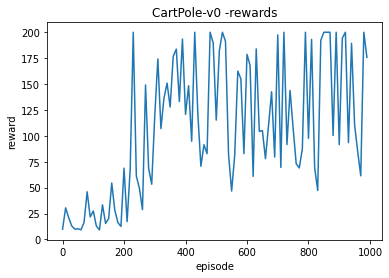

In [11]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_2)
plt.show()

## DQN with Experience Replay Buffer and Target Network

In [12]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [13]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_3 = []
average_list = deque(maxlen=100)
timestep = 0


for episode in tqdm(range(nb_episode)) :
    
    
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_3.append(t)

  1%|▎                                         | 6/1000 [00:00<00:18, 54.16it/s]

episode 0 - test reward : 9.6 - avg : 16.0 - epsilon 0.995


  1%|▍                                        | 12/1000 [00:00<00:33, 29.76it/s]

episode 10 - test reward : 9.5 - avg : 18.636363636363637 - epsilon 0.946354579813443


  3%|█                                        | 26/1000 [00:01<00:38, 25.59it/s]

episode 20 - test reward : 10.2 - avg : 23.0 - epsilon 0.9000874278732445


  4%|█▌                                       | 37/1000 [00:01<00:32, 29.22it/s]

episode 30 - test reward : 9.9 - avg : 20.451612903225808 - epsilon 0.8560822709551227


  5%|██                                       | 49/1000 [00:01<00:28, 33.58it/s]

episode 40 - test reward : 11.0 - avg : 19.24390243902439 - epsilon 0.8142285204175609


  6%|██▎                                      | 57/1000 [00:01<00:30, 30.70it/s]

episode 50 - test reward : 9.8 - avg : 17.941176470588236 - epsilon 0.7744209942832988


  6%|██▋                                      | 65/1000 [00:02<00:31, 29.31it/s]

episode 60 - test reward : 10.3 - avg : 17.934426229508198 - epsilon 0.736559652908221


  8%|███                                      | 76/1000 [00:02<00:28, 32.28it/s]

episode 70 - test reward : 10.2 - avg : 17.43661971830986 - epsilon 0.7005493475733617


  9%|███▌                                     | 88/1000 [00:02<00:26, 34.94it/s]

episode 80 - test reward : 9.8 - avg : 16.938271604938272 - epsilon 0.6662995813682115


 10%|███▉                                     | 96/1000 [00:03<00:27, 32.37it/s]

episode 90 - test reward : 9.1 - avg : 16.428571428571427 - epsilon 0.6337242817644086


 11%|████▎                                   | 109/1000 [00:03<00:24, 36.15it/s]

episode 100 - test reward : 9.5 - avg : 16.09 - epsilon 0.6027415843082742


 12%|████▋                                   | 118/1000 [00:03<00:24, 35.47it/s]

episode 110 - test reward : 9.3 - avg : 15.51 - epsilon 0.5732736268885887


 13%|█████                                   | 126/1000 [00:04<00:26, 33.48it/s]

episode 120 - test reward : 9.4 - avg : 14.0 - epsilon 0.5452463540625918


 13%|█████▎                                  | 134/1000 [00:04<00:29, 29.86it/s]

episode 130 - test reward : 9.4 - avg : 13.93 - epsilon 0.5185893309484582


 14%|█████▋                                  | 142/1000 [00:04<00:29, 28.63it/s]

episode 140 - test reward : 9.6 - avg : 14.12 - epsilon 0.4932355662165453


 16%|██████▏                                 | 155/1000 [00:05<00:34, 24.74it/s]

episode 150 - test reward : 13.3 - avg : 15.54 - epsilon 0.46912134373457726


 16%|██████▌                                 | 164/1000 [00:05<00:38, 21.74it/s]

episode 160 - test reward : 17.8 - avg : 16.01 - epsilon 0.446186062443672


 17%|██████▉                                 | 174/1000 [00:06<00:55, 14.89it/s]

episode 170 - test reward : 16.7 - avg : 18.16 - epsilon 0.42437208406280985


 18%|███████▎                                | 183/1000 [00:07<00:47, 17.06it/s]

episode 180 - test reward : 16.0 - avg : 19.07 - epsilon 0.4036245882390106


 19%|███████▋                                | 193/1000 [00:07<00:56, 14.40it/s]

episode 190 - test reward : 17.5 - avg : 21.16 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [00:08<01:24,  9.40it/s]

episode 200 - test reward : 133.0 - avg : 24.93 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [00:10<01:54,  6.88it/s]

episode 210 - test reward : 194.4 - avg : 30.22 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [00:12<03:13,  4.02it/s]

episode 220 - test reward : 198.5 - avg : 38.02 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [00:14<03:16,  3.91it/s]

episode 230 - test reward : 196.1 - avg : 46.38 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [00:19<05:56,  2.13it/s]

episode 240 - test reward : 187.3 - avg : 63.1 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [00:22<04:46,  2.61it/s]

episode 250 - test reward : 191.8 - avg : 74.43 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [00:26<04:50,  2.55it/s]

episode 260 - test reward : 199.9 - avg : 90.18 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [00:29<04:30,  2.69it/s]

episode 270 - test reward : 200.0 - avg : 104.79 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [00:33<03:37,  3.30it/s]

episode 280 - test reward : 200.0 - avg : 119.23 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [00:37<05:17,  2.24it/s]

episode 290 - test reward : 200.0 - avg : 135.81 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [00:40<04:47,  2.43it/s]

episode 300 - test reward : 200.0 - avg : 150.74 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [00:44<04:57,  2.31it/s]

episode 310 - test reward : 197.0 - avg : 163.62 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [00:48<04:44,  2.39it/s]

episode 320 - test reward : 198.5 - avg : 173.26 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [00:52<04:29,  2.48it/s]

episode 330 - test reward : 200.0 - avg : 182.9 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [00:56<04:38,  2.36it/s]

episode 340 - test reward : 199.6 - avg : 183.81 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [01:00<04:32,  2.38it/s]

episode 350 - test reward : 198.8 - avg : 189.8 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [01:03<04:20,  2.45it/s]

episode 360 - test reward : 195.4 - avg : 190.96 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [01:07<04:23,  2.38it/s]

episode 370 - test reward : 200.0 - avg : 192.51 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [01:11<04:08,  2.49it/s]

episode 380 - test reward : 197.3 - avg : 195.23 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [01:15<03:44,  2.71it/s]

episode 390 - test reward : 199.3 - avg : 193.87 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [01:20<06:24,  1.56it/s]

episode 400 - test reward : 198.6 - avg : 193.29 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [01:25<04:54,  2.00it/s]

episode 410 - test reward : 200.0 - avg : 193.81 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [01:29<04:07,  2.34it/s]

episode 420 - test reward : 200.0 - avg : 195.0 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [01:33<04:03,  2.34it/s]

episode 430 - test reward : 198.3 - avg : 195.1 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [01:37<04:07,  2.26it/s]

episode 440 - test reward : 200.0 - avg : 195.24 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [01:41<03:56,  2.32it/s]

episode 450 - test reward : 192.9 - avg : 195.01 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [01:45<03:46,  2.38it/s]

episode 460 - test reward : 200.0 - avg : 195.6 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [01:49<03:42,  2.37it/s]

episode 470 - test reward : 200.0 - avg : 195.55 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [01:53<03:24,  2.53it/s]

episode 480 - test reward : 168.8 - avg : 195.1 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [01:57<03:33,  2.38it/s]

episode 490 - test reward : 200.0 - avg : 195.96 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [02:01<03:24,  2.44it/s]

episode 500 - test reward : 200.0 - avg : 195.45 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [02:04<03:21,  2.42it/s]

episode 510 - test reward : 196.7 - avg : 195.03 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [02:08<03:15,  2.45it/s]

episode 520 - test reward : 200.0 - avg : 194.52 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [02:12<03:20,  2.34it/s]

episode 530 - test reward : 197.2 - avg : 194.55 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [02:16<03:17,  2.33it/s]

episode 540 - test reward : 200.0 - avg : 194.77 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [02:21<03:13,  2.32it/s]

episode 550 - test reward : 198.9 - avg : 194.85 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [02:24<02:58,  2.46it/s]

episode 560 - test reward : 200.0 - avg : 194.03 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [02:28<03:03,  2.34it/s]

episode 570 - test reward : 200.0 - avg : 193.84 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [02:33<03:01,  2.31it/s]

episode 580 - test reward : 200.0 - avg : 194.7 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [02:37<03:25,  1.99it/s]

episode 590 - test reward : 200.0 - avg : 195.14 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [02:41<02:56,  2.26it/s]

episode 600 - test reward : 199.4 - avg : 195.9 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [02:45<02:54,  2.22it/s]

episode 610 - test reward : 200.0 - avg : 196.26 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [02:50<02:47,  2.26it/s]

episode 620 - test reward : 183.6 - avg : 196.1 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [02:54<02:43,  2.26it/s]

episode 630 - test reward : 200.0 - avg : 196.19 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [02:58<02:38,  2.27it/s]

episode 640 - test reward : 200.0 - avg : 196.33 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [03:02<02:37,  2.22it/s]

episode 650 - test reward : 196.2 - avg : 196.48 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [03:06<02:35,  2.19it/s]

episode 660 - test reward : 200.0 - avg : 197.52 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [03:11<02:25,  2.27it/s]

episode 670 - test reward : 152.3 - avg : 198.0 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [03:15<02:19,  2.28it/s]

episode 680 - test reward : 200.0 - avg : 197.88 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [03:19<02:20,  2.20it/s]

episode 690 - test reward : 200.0 - avg : 197.14 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [03:23<02:13,  2.24it/s]

episode 700 - test reward : 150.7 - avg : 197.33 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [03:27<02:05,  2.30it/s]

episode 710 - test reward : 200.0 - avg : 196.86 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [03:32<02:06,  2.21it/s]

episode 720 - test reward : 191.3 - avg : 197.59 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [03:36<02:00,  2.24it/s]

episode 730 - test reward : 183.1 - avg : 197.8 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [03:40<02:01,  2.14it/s]

episode 740 - test reward : 178.3 - avg : 197.93 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [03:45<01:47,  2.32it/s]

episode 750 - test reward : 200.0 - avg : 196.69 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [03:49<01:46,  2.23it/s]

episode 760 - test reward : 161.0 - avg : 196.09 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [03:53<01:43,  2.22it/s]

episode 770 - test reward : 200.0 - avg : 195.13 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [03:57<01:42,  2.14it/s]

episode 780 - test reward : 200.0 - avg : 195.04 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [04:02<01:38,  2.13it/s]

episode 790 - test reward : 200.0 - avg : 195.79 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [04:08<01:32,  2.16it/s]

episode 800 - test reward : 200.0 - avg : 195.16 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [04:12<01:26,  2.19it/s]

episode 810 - test reward : 200.0 - avg : 195.69 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [04:16<01:24,  2.12it/s]

episode 820 - test reward : 200.0 - avg : 195.73 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [04:21<01:18,  2.15it/s]

episode 830 - test reward : 200.0 - avg : 195.86 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [04:25<01:13,  2.15it/s]

episode 840 - test reward : 200.0 - avg : 195.86 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [04:30<01:09,  2.15it/s]

episode 850 - test reward : 200.0 - avg : 197.1 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [04:34<01:04,  2.16it/s]

episode 860 - test reward : 200.0 - avg : 197.72 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [04:39<01:02,  2.05it/s]

episode 870 - test reward : 200.0 - avg : 198.69 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [04:43<00:55,  2.14it/s]

episode 880 - test reward : 200.0 - avg : 199.08 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [04:48<00:51,  2.12it/s]

episode 890 - test reward : 200.0 - avg : 199.23 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [04:52<00:46,  2.12it/s]

episode 900 - test reward : 176.7 - avg : 200.0 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [04:57<00:41,  2.16it/s]

episode 910 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [05:01<00:36,  2.18it/s]

episode 920 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [05:05<00:31,  2.17it/s]

episode 930 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [05:10<00:27,  2.14it/s]

episode 940 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [05:14<00:22,  2.14it/s]

episode 950 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [05:19<00:18,  2.11it/s]

episode 960 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [05:23<00:13,  2.12it/s]

episode 970 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [05:28<00:09,  2.04it/s]

episode 980 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [05:32<00:04,  2.09it/s]

episode 990 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [05:36<00:00,  2.97it/s]


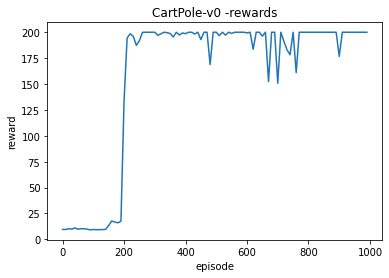

In [14]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_3)
plt.show()

## Double DQN with Experience Replay Buffer and Target Network

In [15]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [16]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_4 = []
timestep = 0
average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0:
        
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
            timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_4.append(t)

  1%|▎                                         | 6/1000 [00:00<00:19, 50.44it/s]

episode 0 - test reward : 9.4 - avg : 13.0 - epsilon 0.995


  1%|▍                                        | 12/1000 [00:00<00:32, 30.04it/s]

episode 10 - test reward : 20.8 - avg : 18.363636363636363 - epsilon 0.946354579813443


  2%|▉                                        | 22/1000 [00:00<00:47, 20.79it/s]

episode 20 - test reward : 26.8 - avg : 19.666666666666668 - epsilon 0.9000874278732445


  4%|█▍                                       | 35/1000 [00:01<00:47, 20.12it/s]

episode 30 - test reward : 10.8 - avg : 22.70967741935484 - epsilon 0.8560822709551227


  4%|█▊                                       | 44/1000 [00:02<00:46, 20.56it/s]

episode 40 - test reward : 10.4 - avg : 22.902439024390244 - epsilon 0.8142285204175609


  5%|██▏                                      | 53/1000 [00:02<00:41, 22.81it/s]

episode 50 - test reward : 12.0 - avg : 21.50980392156863 - epsilon 0.7744209942832988


  6%|██▌                                      | 62/1000 [00:02<00:41, 22.58it/s]

episode 60 - test reward : 11.2 - avg : 21.34426229508197 - epsilon 0.736559652908221


  8%|███                                      | 75/1000 [00:03<00:38, 24.01it/s]

episode 70 - test reward : 10.2 - avg : 20.816901408450704 - epsilon 0.7005493475733617


  8%|███▍                                     | 85/1000 [00:03<00:36, 24.87it/s]

episode 80 - test reward : 18.5 - avg : 20.666666666666668 - epsilon 0.6662995813682115


  9%|███▊                                     | 94/1000 [00:04<00:38, 23.67it/s]

episode 90 - test reward : 9.3 - avg : 20.263736263736263 - epsilon 0.6337242817644086


 10%|████                                    | 103/1000 [00:04<00:40, 22.03it/s]

episode 100 - test reward : 9.5 - avg : 19.99 - epsilon 0.6027415843082742


 12%|████▋                                   | 116/1000 [00:05<00:38, 22.86it/s]

episode 110 - test reward : 24.1 - avg : 20.12 - epsilon 0.5732736268885887


 12%|████▉                                   | 124/1000 [00:05<00:47, 18.58it/s]

episode 120 - test reward : 30.8 - avg : 20.23 - epsilon 0.5452463540625918


 13%|█████▎                                  | 134/1000 [00:06<00:46, 18.57it/s]

episode 130 - test reward : 35.9 - avg : 20.25 - epsilon 0.5185893309484582


 14%|█████▊                                  | 145/1000 [00:06<00:41, 20.76it/s]

episode 140 - test reward : 24.9 - avg : 19.73 - epsilon 0.4932355662165453


 15%|██████▏                                 | 154/1000 [00:07<00:41, 20.48it/s]

episode 150 - test reward : 31.4 - avg : 19.91 - epsilon 0.46912134373457726


 16%|██████▌                                 | 163/1000 [00:07<01:00, 13.89it/s]

episode 160 - test reward : 40.7 - avg : 21.15 - epsilon 0.446186062443672


 17%|██████▉                                 | 172/1000 [00:08<01:10, 11.70it/s]

episode 170 - test reward : 77.0 - avg : 22.76 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [00:09<01:04, 12.69it/s]

episode 180 - test reward : 182.9 - avg : 23.63 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [00:11<02:23,  5.62it/s]

episode 190 - test reward : 197.8 - avg : 29.36 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [00:12<02:07,  6.26it/s]

episode 200 - test reward : 124.8 - avg : 33.98 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [00:15<03:43,  3.53it/s]

episode 210 - test reward : 182.6 - avg : 43.55 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [00:17<04:15,  3.05it/s]

episode 220 - test reward : 170.0 - avg : 53.7 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [00:21<04:53,  2.62it/s]

episode 230 - test reward : 191.2 - avg : 66.19 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [00:24<04:26,  2.85it/s]

episode 240 - test reward : 185.2 - avg : 79.44 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [00:28<04:46,  2.62it/s]

episode 250 - test reward : 183.7 - avg : 94.46 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [00:31<04:55,  2.50it/s]

episode 260 - test reward : 197.9 - avg : 108.3 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [00:35<05:15,  2.31it/s]

episode 270 - test reward : 197.7 - avg : 124.39 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [00:39<06:08,  1.95it/s]

episode 280 - test reward : 198.6 - avg : 139.75 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [00:43<03:50,  3.07it/s]

episode 290 - test reward : 196.4 - avg : 148.77 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [00:47<04:54,  2.37it/s]

episode 300 - test reward : 199.0 - avg : 162.23 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [00:50<03:59,  2.88it/s]

episode 310 - test reward : 195.1 - avg : 167.26 - epsilon 0.21036724137609603


 32%|████████████▉                           | 322/1000 [00:54<03:39,  3.09it/s]

episode 320 - test reward : 198.0 - avg : 174.04 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [00:58<04:31,  2.47it/s]

episode 330 - test reward : 195.6 - avg : 175.61 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [01:01<04:26,  2.47it/s]

episode 340 - test reward : 162.0 - avg : 176.07 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [01:05<04:26,  2.44it/s]

episode 350 - test reward : 194.1 - avg : 176.52 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [01:08<03:54,  2.72it/s]

episode 360 - test reward : 193.8 - avg : 176.2 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [01:12<04:12,  2.49it/s]

episode 370 - test reward : 159.4 - avg : 175.51 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [01:16<03:42,  2.78it/s]

episode 380 - test reward : 176.6 - avg : 173.54 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [01:19<03:16,  3.09it/s]

episode 390 - test reward : 196.9 - avg : 172.56 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [01:23<03:29,  2.86it/s]

episode 400 - test reward : 195.0 - avg : 169.98 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [01:26<03:45,  2.61it/s]

episode 410 - test reward : 194.1 - avg : 170.42 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [01:29<03:01,  3.19it/s]

episode 420 - test reward : 131.1 - avg : 165.57 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [01:32<02:48,  3.39it/s]

episode 430 - test reward : 123.3 - avg : 161.19 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [01:35<02:36,  3.57it/s]

episode 440 - test reward : 121.5 - avg : 159.48 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [01:38<03:02,  3.01it/s]

episode 450 - test reward : 118.0 - avg : 155.49 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [01:40<02:27,  3.65it/s]

episode 460 - test reward : 118.2 - avg : 150.39 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [01:43<02:29,  3.55it/s]

episode 470 - test reward : 123.2 - avg : 143.43 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [01:46<02:27,  3.53it/s]

episode 480 - test reward : 123.7 - avg : 139.22 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [01:48<02:20,  3.63it/s]

episode 490 - test reward : 118.2 - avg : 134.95 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [01:51<02:20,  3.55it/s]

episode 500 - test reward : 115.3 - avg : 129.51 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [01:53<02:17,  3.57it/s]

episode 510 - test reward : 118.8 - avg : 123.98 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [01:56<02:20,  3.42it/s]

episode 520 - test reward : 118.1 - avg : 121.23 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [01:59<02:15,  3.47it/s]

episode 530 - test reward : 116.4 - avg : 120.32 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [02:01<02:06,  3.61it/s]

episode 540 - test reward : 113.9 - avg : 118.43 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [02:04<02:14,  3.34it/s]

episode 550 - test reward : 115.0 - avg : 117.48 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [02:07<02:05,  3.51it/s]

episode 560 - test reward : 116.2 - avg : 117.38 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [02:10<02:07,  3.35it/s]

episode 570 - test reward : 124.6 - avg : 118.22 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [02:13<02:07,  3.29it/s]

episode 580 - test reward : 121.5 - avg : 118.48 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [02:15<02:00,  3.41it/s]

episode 590 - test reward : 127.0 - avg : 119.45 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [02:18<01:54,  3.48it/s]

episode 600 - test reward : 116.5 - avg : 120.46 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [02:21<01:53,  3.43it/s]

episode 610 - test reward : 119.5 - avg : 122.15 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [02:24<01:50,  3.43it/s]

episode 620 - test reward : 122.3 - avg : 122.8 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [02:27<01:58,  3.12it/s]

episode 630 - test reward : 120.8 - avg : 124.18 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [02:30<01:43,  3.46it/s]

episode 640 - test reward : 119.2 - avg : 124.18 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [02:32<01:42,  3.39it/s]

episode 650 - test reward : 119.8 - avg : 123.94 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [02:35<01:39,  3.42it/s]

episode 660 - test reward : 124.3 - avg : 124.52 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [02:38<01:35,  3.43it/s]

episode 670 - test reward : 120.3 - avg : 123.72 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [02:41<01:35,  3.36it/s]

episode 680 - test reward : 126.0 - avg : 123.57 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [02:44<01:34,  3.26it/s]

episode 690 - test reward : 122.7 - avg : 123.92 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [02:47<01:29,  3.34it/s]

episode 700 - test reward : 124.9 - avg : 123.51 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [02:49<01:31,  3.16it/s]

episode 710 - test reward : 136.1 - avg : 123.14 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [02:53<01:37,  2.86it/s]

episode 720 - test reward : 136.6 - avg : 124.32 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [02:56<01:29,  3.01it/s]

episode 730 - test reward : 132.4 - avg : 124.68 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [02:59<01:24,  3.08it/s]

episode 740 - test reward : 140.9 - avg : 125.56 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [03:02<01:30,  2.75it/s]

episode 750 - test reward : 129.1 - avg : 126.88 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [03:06<01:20,  2.95it/s]

episode 760 - test reward : 131.1 - avg : 128.95 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [03:09<01:22,  2.79it/s]

episode 770 - test reward : 144.9 - avg : 131.6 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [03:12<01:11,  3.06it/s]

episode 780 - test reward : 137.0 - avg : 133.43 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [03:16<01:11,  2.93it/s]

episode 790 - test reward : 136.8 - avg : 135.38 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [03:19<01:08,  2.90it/s]

episode 800 - test reward : 126.7 - avg : 137.76 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [03:22<01:09,  2.74it/s]

episode 810 - test reward : 129.4 - avg : 140.15 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [03:26<01:10,  2.55it/s]

episode 820 - test reward : 139.4 - avg : 142.38 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [03:29<00:59,  2.85it/s]

episode 830 - test reward : 148.7 - avg : 143.65 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [03:33<00:58,  2.74it/s]

episode 840 - test reward : 138.9 - avg : 146.85 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [03:37<00:58,  2.53it/s]

episode 850 - test reward : 140.3 - avg : 149.26 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [03:41<01:02,  2.21it/s]

episode 860 - test reward : 187.3 - avg : 153.23 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [03:45<00:57,  2.24it/s]

episode 870 - test reward : 179.2 - avg : 156.98 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [03:49<00:51,  2.31it/s]

episode 880 - test reward : 200.0 - avg : 161.1 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [03:53<00:49,  2.18it/s]

episode 890 - test reward : 192.6 - avg : 165.23 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [03:58<00:46,  2.12it/s]

episode 900 - test reward : 193.0 - avg : 170.06 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [04:02<00:42,  2.08it/s]

episode 910 - test reward : 200.0 - avg : 174.03 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [04:07<00:37,  2.13it/s]

episode 920 - test reward : 188.1 - avg : 177.14 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [04:11<00:33,  2.03it/s]

episode 930 - test reward : 200.0 - avg : 181.96 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [04:16<00:28,  2.05it/s]

episode 940 - test reward : 200.0 - avg : 185.94 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [04:20<00:24,  2.04it/s]

episode 950 - test reward : 200.0 - avg : 190.16 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [04:25<00:19,  2.05it/s]

episode 960 - test reward : 200.0 - avg : 191.93 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [04:30<00:13,  2.10it/s]

episode 970 - test reward : 200.0 - avg : 193.65 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [04:34<00:09,  2.05it/s]

episode 980 - test reward : 200.0 - avg : 195.26 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [04:39<00:04,  2.06it/s]

episode 990 - test reward : 200.0 - avg : 196.66 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [04:43<00:00,  3.53it/s]


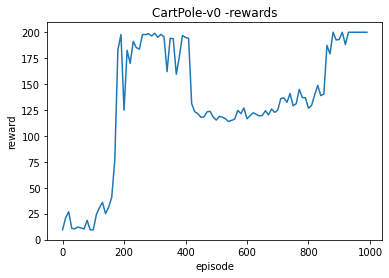

In [17]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_4)
plt.show()

## Dueling DQN with Experience Replay Buffer and Target Network

In [18]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1
tau = 1e-3 

In [19]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_5 = []
timestep = 0

average_list = deque(maxlen=100)


for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() > epsilon :
            action = torch.argmax(q_target_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_5.append(t)

  0%|▏                                         | 4/1000 [00:00<00:39, 25.19it/s]

episode 0 - test reward : 9.2 - avg : 17.0 - epsilon 0.995


  1%|▌                                        | 13/1000 [00:00<01:06, 14.78it/s]

episode 10 - test reward : 12.3 - avg : 23.181818181818183 - epsilon 0.946354579813443


  2%|▉                                        | 23/1000 [00:01<01:12, 13.53it/s]

episode 20 - test reward : 15.4 - avg : 21.571428571428573 - epsilon 0.9000874278732445


  3%|█▎                                       | 33/1000 [00:02<01:08, 14.22it/s]

episode 30 - test reward : 9.6 - avg : 21.64516129032258 - epsilon 0.8560822709551227


  4%|█▊                                       | 44/1000 [00:03<01:05, 14.68it/s]

episode 40 - test reward : 9.5 - avg : 21.24390243902439 - epsilon 0.8142285204175609


  5%|██▏                                      | 52/1000 [00:03<01:12, 13.14it/s]

episode 50 - test reward : 32.6 - avg : 20.294117647058822 - epsilon 0.7744209942832988


  6%|██▌                                      | 62/1000 [00:04<01:27, 10.70it/s]

episode 60 - test reward : 30.0 - avg : 20.081967213114755 - epsilon 0.736559652908221


  7%|██▉                                      | 73/1000 [00:05<01:14, 12.49it/s]

episode 70 - test reward : 30.7 - avg : 19.760563380281692 - epsilon 0.7005493475733617


  8%|███▍                                     | 84/1000 [00:06<01:06, 13.73it/s]

episode 80 - test reward : 34.3 - avg : 19.703703703703702 - epsilon 0.6662995813682115


  9%|███▊                                     | 93/1000 [00:06<00:59, 15.35it/s]

episode 90 - test reward : 28.2 - avg : 19.065934065934066 - epsilon 0.6337242817644086


 10%|████▏                                   | 104/1000 [00:07<00:54, 16.35it/s]

episode 100 - test reward : 10.8 - avg : 18.6 - epsilon 0.6027415843082742


 11%|████▌                                   | 113/1000 [00:08<01:07, 13.07it/s]

episode 110 - test reward : 60.9 - avg : 17.78 - epsilon 0.5732736268885887


 12%|████▉                                   | 122/1000 [00:08<01:23, 10.51it/s]

episode 120 - test reward : 67.8 - avg : 17.07 - epsilon 0.5452463540625918


 14%|█████▍                                  | 135/1000 [00:10<01:06, 12.96it/s]

episode 130 - test reward : 31.7 - avg : 16.82 - epsilon 0.5185893309484582


 14%|█████▊                                  | 145/1000 [00:11<01:15, 11.33it/s]

episode 140 - test reward : 114.4 - avg : 15.96 - epsilon 0.4932355662165453


 15%|██████                                  | 153/1000 [00:11<01:22, 10.27it/s]

episode 150 - test reward : 99.9 - avg : 15.77 - epsilon 0.46912134373457726


 16%|██████▍                                 | 162/1000 [00:12<01:21, 10.26it/s]

episode 160 - test reward : 38.6 - avg : 15.24 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [00:13<01:21, 10.14it/s]

episode 170 - test reward : 38.1 - avg : 14.84 - epsilon 0.42437208406280985


 18%|███████▎                                | 183/1000 [00:14<01:47,  7.61it/s]

episode 180 - test reward : 151.3 - avg : 14.44 - epsilon 0.4036245882390106


 19%|███████▋                                | 193/1000 [00:15<01:18, 10.25it/s]

episode 190 - test reward : 64.7 - avg : 14.72 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [00:17<02:05,  6.36it/s]

episode 200 - test reward : 163.2 - avg : 14.99 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [00:18<01:38,  8.01it/s]

episode 210 - test reward : 54.3 - avg : 15.54 - epsilon 0.3472722151889232


 22%|████████▉                               | 222/1000 [00:19<02:33,  5.08it/s]

episode 220 - test reward : 184.6 - avg : 16.36 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [00:22<05:39,  2.26it/s]

episode 230 - test reward : 198.6 - avg : 17.81 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [00:33<14:35,  1.15s/it]

episode 240 - test reward : 153.0 - avg : 32.24 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [00:40<09:10,  1.36it/s]

episode 250 - test reward : 139.7 - avg : 48.86 - epsilon 0.28417984116121187


 26%|██████████▍                             | 262/1000 [00:45<05:50,  2.11it/s]

episode 260 - test reward : 163.0 - avg : 61.89 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [00:51<08:32,  1.42it/s]

episode 270 - test reward : 145.8 - avg : 74.71 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [00:57<08:44,  1.37it/s]

episode 280 - test reward : 180.6 - avg : 89.48 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [01:03<09:02,  1.31it/s]

episode 290 - test reward : 190.6 - avg : 105.02 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [01:09<09:02,  1.29it/s]

episode 300 - test reward : 183.2 - avg : 119.25 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [01:16<08:41,  1.32it/s]

episode 310 - test reward : 195.7 - avg : 134.86 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [01:22<08:59,  1.26it/s]

episode 320 - test reward : 197.0 - avg : 151.45 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [01:29<08:25,  1.32it/s]

episode 330 - test reward : 176.6 - avg : 166.28 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [01:36<08:06,  1.36it/s]

episode 340 - test reward : 173.9 - avg : 167.72 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [01:42<07:45,  1.39it/s]

episode 350 - test reward : 176.7 - avg : 166.51 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [01:48<08:00,  1.33it/s]

episode 360 - test reward : 167.7 - avg : 169.94 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [01:55<07:32,  1.39it/s]

episode 370 - test reward : 169.6 - avg : 172.78 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [02:01<07:52,  1.31it/s]

episode 380 - test reward : 178.7 - avg : 172.92 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [02:07<07:26,  1.36it/s]

episode 390 - test reward : 151.0 - avg : 172.6 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [02:13<06:45,  1.48it/s]

episode 400 - test reward : 164.6 - avg : 172.26 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [02:19<07:08,  1.38it/s]

episode 410 - test reward : 158.4 - avg : 168.81 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [02:25<06:45,  1.43it/s]

episode 420 - test reward : 149.7 - avg : 166.34 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [02:31<05:06,  1.86it/s]

episode 430 - test reward : 155.8 - avg : 162.73 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [02:37<06:46,  1.37it/s]

episode 440 - test reward : 161.9 - avg : 161.65 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [02:43<06:25,  1.42it/s]

episode 450 - test reward : 197.1 - avg : 159.66 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [02:48<05:39,  1.59it/s]

episode 460 - test reward : 150.4 - avg : 154.78 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [02:54<05:52,  1.50it/s]

episode 470 - test reward : 150.7 - avg : 153.15 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [02:59<05:47,  1.50it/s]

episode 480 - test reward : 157.4 - avg : 150.92 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [03:05<05:47,  1.47it/s]

episode 490 - test reward : 150.1 - avg : 148.89 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [03:11<05:32,  1.50it/s]

episode 500 - test reward : 165.6 - avg : 147.7 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [03:16<05:16,  1.55it/s]

episode 510 - test reward : 145.9 - avg : 147.53 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [03:22<04:45,  1.68it/s]

episode 520 - test reward : 140.5 - avg : 144.61 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [03:27<04:49,  1.62it/s]

episode 530 - test reward : 148.5 - avg : 143.93 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [03:32<03:54,  1.95it/s]

episode 540 - test reward : 135.8 - avg : 140.32 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [03:38<05:00,  1.49it/s]

episode 550 - test reward : 192.1 - avg : 139.73 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [03:43<04:49,  1.52it/s]

episode 560 - test reward : 175.0 - avg : 140.32 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [03:48<04:04,  1.75it/s]

episode 570 - test reward : 151.5 - avg : 137.98 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [03:54<04:53,  1.43it/s]

episode 580 - test reward : 200.0 - avg : 138.57 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [04:01<05:27,  1.25it/s]

episode 590 - test reward : 200.0 - avg : 140.74 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [04:08<05:31,  1.20it/s]

episode 600 - test reward : 196.0 - avg : 143.31 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [04:15<05:30,  1.18it/s]

episode 610 - test reward : 155.0 - avg : 148.69 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [04:24<05:49,  1.08it/s]

episode 620 - test reward : 200.0 - avg : 155.38 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [04:31<04:56,  1.25it/s]

episode 630 - test reward : 106.1 - avg : 161.06 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [04:38<05:18,  1.13it/s]

episode 640 - test reward : 200.0 - avg : 168.57 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [04:46<05:20,  1.09it/s]

episode 650 - test reward : 200.0 - avg : 174.29 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [04:54<05:07,  1.10it/s]

episode 660 - test reward : 200.0 - avg : 180.75 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [05:02<05:00,  1.09it/s]

episode 670 - test reward : 200.0 - avg : 187.68 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [05:10<04:49,  1.10it/s]

episode 680 - test reward : 200.0 - avg : 192.88 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [05:18<04:38,  1.11it/s]

episode 690 - test reward : 200.0 - avg : 195.85 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [05:26<04:43,  1.05it/s]

episode 700 - test reward : 200.0 - avg : 198.89 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [05:34<04:22,  1.10it/s]

episode 710 - test reward : 200.0 - avg : 199.41 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [05:42<04:12,  1.10it/s]

episode 720 - test reward : 200.0 - avg : 199.43 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [05:50<04:04,  1.10it/s]

episode 730 - test reward : 200.0 - avg : 199.83 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [05:58<03:53,  1.11it/s]

episode 740 - test reward : 183.0 - avg : 200.0 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [06:06<03:48,  1.09it/s]

episode 750 - test reward : 200.0 - avg : 200.0 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [06:14<03:39,  1.09it/s]

episode 760 - test reward : 200.0 - avg : 200.0 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [06:22<03:42,  1.03it/s]

episode 770 - test reward : 200.0 - avg : 200.0 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [06:30<03:19,  1.10it/s]

episode 780 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [06:38<03:07,  1.11it/s]

episode 790 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [06:46<03:03,  1.08it/s]

episode 800 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [06:54<02:50,  1.11it/s]

episode 810 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [07:02<02:47,  1.07it/s]

episode 820 - test reward : 200.0 - avg : 199.98 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [07:10<02:33,  1.10it/s]

episode 830 - test reward : 200.0 - avg : 199.87 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [07:17<02:20,  1.13it/s]

episode 840 - test reward : 183.8 - avg : 199.77 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [07:25<02:18,  1.08it/s]

episode 850 - test reward : 200.0 - avg : 199.77 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [07:33<01:58,  1.17it/s]

episode 860 - test reward : 137.8 - avg : 199.77 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [07:41<01:52,  1.15it/s]

episode 870 - test reward : 188.6 - avg : 199.29 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [07:48<01:38,  1.20it/s]

episode 880 - test reward : 195.2 - avg : 197.71 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [07:55<01:31,  1.19it/s]

episode 890 - test reward : 188.7 - avg : 196.83 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [08:03<01:30,  1.10it/s]

episode 900 - test reward : 200.0 - avg : 196.83 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [08:11<01:20,  1.11it/s]

episode 910 - test reward : 200.0 - avg : 196.62 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [08:19<01:09,  1.13it/s]

episode 920 - test reward : 189.8 - avg : 196.51 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [08:27<01:01,  1.11it/s]

episode 930 - test reward : 177.5 - avg : 196.62 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [08:34<00:46,  1.27it/s]

episode 940 - test reward : 172.7 - avg : 195.05 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [08:41<00:39,  1.23it/s]

episode 950 - test reward : 199.9 - avg : 192.65 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [08:49<00:34,  1.12it/s]

episode 960 - test reward : 200.0 - avg : 191.56 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [08:57<00:25,  1.12it/s]

episode 970 - test reward : 199.8 - avg : 192.04 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [09:05<00:17,  1.11it/s]

episode 980 - test reward : 200.0 - avg : 193.62 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [09:12<00:08,  1.11it/s]

episode 990 - test reward : 197.2 - avg : 194.5 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [09:19<00:00,  1.79it/s]


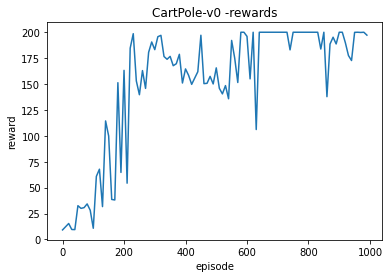

In [20]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_5)
plt.show()

## Dueling Double DQN with Experience Replay Buffer and Target Network (D3QN)

In [21]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1
tau = 1e-3 

In [22]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_6 = []
timestep = 0

average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)

        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_6.append(t)

  0%|▏                                         | 4/1000 [00:00<00:30, 32.92it/s]

episode 0 - test reward : 9.1 - avg : 12.0 - epsilon 0.995


  1%|▌                                        | 13/1000 [00:00<00:59, 16.63it/s]

episode 10 - test reward : 11.2 - avg : 18.363636363636363 - epsilon 0.946354579813443


  2%|▉                                        | 23/1000 [00:01<01:22, 11.78it/s]

episode 20 - test reward : 9.7 - avg : 18.38095238095238 - epsilon 0.9000874278732445


  3%|█▎                                       | 33/1000 [00:02<01:23, 11.65it/s]

episode 30 - test reward : 23.2 - avg : 19.161290322580644 - epsilon 0.8560822709551227


  4%|█▊                                       | 43/1000 [00:03<01:30, 10.52it/s]

episode 40 - test reward : 21.4 - avg : 19.48780487804878 - epsilon 0.8142285204175609


  5%|██▏                                      | 53/1000 [00:04<01:11, 13.19it/s]

episode 50 - test reward : 9.2 - avg : 19.431372549019606 - epsilon 0.7744209942832988


  6%|██▌                                      | 63/1000 [00:04<01:10, 13.35it/s]

episode 60 - test reward : 9.5 - avg : 19.327868852459016 - epsilon 0.736559652908221


  7%|██▉                                      | 73/1000 [00:05<01:17, 11.91it/s]

episode 70 - test reward : 12.4 - avg : 19.154929577464788 - epsilon 0.7005493475733617


  8%|███▍                                     | 83/1000 [00:06<01:22, 11.08it/s]

episode 80 - test reward : 9.1 - avg : 19.209876543209877 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [00:07<01:21, 11.15it/s]

episode 90 - test reward : 13.3 - avg : 19.021978021978022 - epsilon 0.6337242817644086


 10%|████                                    | 102/1000 [00:08<01:06, 13.43it/s]

episode 100 - test reward : 13.4 - avg : 18.7 - epsilon 0.6027415843082742


 11%|████▍                                   | 112/1000 [00:09<01:34,  9.43it/s]

episode 110 - test reward : 15.4 - avg : 19.27 - epsilon 0.5732736268885887


 12%|████▉                                   | 122/1000 [00:10<01:14, 11.78it/s]

episode 120 - test reward : 12.4 - avg : 19.25 - epsilon 0.5452463540625918


 13%|█████▎                                  | 132/1000 [00:11<01:24, 10.28it/s]

episode 130 - test reward : 11.6 - avg : 19.5 - epsilon 0.5185893309484582


 14%|█████▋                                  | 143/1000 [00:11<01:05, 13.13it/s]

episode 140 - test reward : 26.2 - avg : 19.01 - epsilon 0.4932355662165453


 15%|██████                                  | 152/1000 [00:13<02:40,  5.27it/s]

episode 150 - test reward : 100.1 - avg : 20.5 - epsilon 0.46912134373457726


 16%|██████▍                                 | 161/1000 [00:14<02:19,  6.03it/s]

episode 160 - test reward : 53.8 - avg : 21.45 - epsilon 0.446186062443672


 17%|██████▉                                 | 172/1000 [00:16<03:20,  4.14it/s]

episode 170 - test reward : 194.4 - avg : 22.69 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [00:19<07:29,  1.82it/s]

episode 180 - test reward : 186.9 - avg : 25.57 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [00:22<05:37,  2.40it/s]

episode 190 - test reward : 188.1 - avg : 28.85 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [00:25<05:24,  2.46it/s]

episode 200 - test reward : 194.2 - avg : 32.75 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [00:29<07:36,  1.73it/s]

episode 210 - test reward : 197.4 - avg : 39.28 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [00:36<12:09,  1.07it/s]

episode 220 - test reward : 191.4 - avg : 50.41 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [00:44<11:48,  1.08it/s]

episode 230 - test reward : 200.0 - avg : 63.14 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [00:51<11:45,  1.08it/s]

episode 240 - test reward : 200.0 - avg : 76.77 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [00:59<10:47,  1.16it/s]

episode 250 - test reward : 200.0 - avg : 90.49 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [01:07<11:11,  1.10it/s]

episode 260 - test reward : 200.0 - avg : 104.95 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [01:14<08:51,  1.37it/s]

episode 270 - test reward : 200.0 - avg : 118.31 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [01:22<10:33,  1.14it/s]

episode 280 - test reward : 200.0 - avg : 132.19 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [01:29<10:20,  1.14it/s]

episode 290 - test reward : 200.0 - avg : 144.64 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [01:37<09:29,  1.23it/s]

episode 300 - test reward : 200.0 - avg : 157.7 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [01:44<09:12,  1.25it/s]

episode 310 - test reward : 200.0 - avg : 166.45 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [01:53<10:55,  1.04it/s]

episode 320 - test reward : 199.3 - avg : 173.37 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [02:01<10:36,  1.05it/s]

episode 330 - test reward : 197.9 - avg : 177.77 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [02:07<08:31,  1.29it/s]

episode 340 - test reward : 191.9 - avg : 177.07 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [02:14<09:11,  1.18it/s]

episode 350 - test reward : 200.0 - avg : 176.58 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [02:22<09:58,  1.07it/s]

episode 360 - test reward : 197.9 - avg : 178.78 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [02:31<09:44,  1.08it/s]

episode 370 - test reward : 195.7 - avg : 182.04 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [02:38<08:23,  1.23it/s]

episode 380 - test reward : 184.5 - avg : 180.65 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [02:46<09:35,  1.06it/s]

episode 390 - test reward : 196.0 - avg : 182.63 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [02:54<09:24,  1.06it/s]

episode 400 - test reward : 192.7 - avg : 184.1 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [03:03<10:05,  1.03s/it]

episode 410 - test reward : 195.3 - avg : 184.87 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [03:09<06:53,  1.40it/s]

episode 420 - test reward : 177.0 - avg : 180.39 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [03:17<08:24,  1.13it/s]

episode 430 - test reward : 177.8 - avg : 179.52 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [03:25<07:28,  1.25it/s]

episode 440 - test reward : 164.8 - avg : 182.63 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [03:33<08:15,  1.11it/s]

episode 450 - test reward : 171.4 - avg : 184.64 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [03:40<08:03,  1.11it/s]

episode 460 - test reward : 189.6 - avg : 183.74 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [03:48<07:54,  1.11it/s]

episode 470 - test reward : 179.6 - avg : 183.23 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [03:57<08:09,  1.06it/s]

episode 480 - test reward : 191.6 - avg : 185.16 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [04:05<08:10,  1.04it/s]

episode 490 - test reward : 198.3 - avg : 185.67 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [04:14<07:42,  1.08it/s]

episode 500 - test reward : 196.9 - avg : 185.16 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [04:22<07:14,  1.13it/s]

episode 510 - test reward : 141.2 - avg : 185.81 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [04:30<07:42,  1.04it/s]

episode 520 - test reward : 200.0 - avg : 189.85 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [04:39<07:11,  1.09it/s]

episode 530 - test reward : 170.6 - avg : 190.86 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [04:47<07:07,  1.07it/s]

episode 540 - test reward : 199.0 - avg : 192.45 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [04:55<06:36,  1.13it/s]

episode 550 - test reward : 182.0 - avg : 192.57 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [05:02<05:57,  1.23it/s]

episode 560 - test reward : 145.2 - avg : 191.21 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [05:09<05:52,  1.22it/s]

episode 570 - test reward : 156.0 - avg : 188.53 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [05:16<05:16,  1.32it/s]

episode 580 - test reward : 139.0 - avg : 185.53 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [05:23<05:24,  1.26it/s]

episode 590 - test reward : 145.2 - avg : 182.08 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [05:30<04:55,  1.35it/s]

episode 600 - test reward : 146.9 - avg : 178.3 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [05:36<04:40,  1.39it/s]

episode 610 - test reward : 135.2 - avg : 174.1 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [05:43<04:45,  1.33it/s]

episode 620 - test reward : 133.4 - avg : 170.32 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [05:50<04:30,  1.36it/s]

episode 630 - test reward : 130.1 - avg : 166.37 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [05:57<04:36,  1.30it/s]

episode 640 - test reward : 178.0 - avg : 162.64 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [06:04<04:53,  1.19it/s]

episode 650 - test reward : 181.4 - avg : 159.36 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [06:11<04:34,  1.23it/s]

episode 660 - test reward : 179.4 - avg : 157.47 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [06:18<04:16,  1.28it/s]

episode 670 - test reward : 165.5 - avg : 156.44 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [06:25<03:58,  1.34it/s]

episode 680 - test reward : 141.8 - avg : 155.71 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [06:32<04:02,  1.28it/s]

episode 690 - test reward : 138.7 - avg : 154.69 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [06:39<03:53,  1.28it/s]

episode 700 - test reward : 162.1 - avg : 154.32 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [06:45<03:26,  1.40it/s]

episode 710 - test reward : 143.0 - avg : 154.21 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [06:52<03:34,  1.30it/s]

episode 720 - test reward : 157.2 - avg : 153.73 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [06:59<03:20,  1.34it/s]

episode 730 - test reward : 141.5 - avg : 152.94 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [07:06<03:19,  1.30it/s]

episode 740 - test reward : 143.5 - avg : 152.34 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [07:12<03:10,  1.31it/s]

episode 750 - test reward : 155.7 - avg : 152.2 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [07:19<03:10,  1.25it/s]

episode 760 - test reward : 144.9 - avg : 152.72 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [07:27<03:15,  1.17it/s]

episode 770 - test reward : 160.8 - avg : 154.09 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [07:35<03:22,  1.08it/s]

episode 780 - test reward : 199.0 - avg : 156.54 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [07:42<02:58,  1.17it/s]

episode 790 - test reward : 199.9 - avg : 158.44 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [07:50<02:50,  1.17it/s]

episode 800 - test reward : 152.5 - avg : 160.97 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [07:58<03:00,  1.05it/s]

episode 810 - test reward : 199.7 - avg : 165.17 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [08:07<02:40,  1.11it/s]

episode 820 - test reward : 154.8 - avg : 168.67 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [08:15<02:48,  1.01it/s]

episode 830 - test reward : 200.0 - avg : 173.46 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [08:24<02:27,  1.08it/s]

episode 840 - test reward : 139.0 - avg : 178.49 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [08:33<02:23,  1.04it/s]

episode 850 - test reward : 171.0 - avg : 183.14 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [08:42<02:21,  1.02s/it]

episode 860 - test reward : 197.6 - avg : 187.28 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [08:50<02:09,  1.01s/it]

episode 870 - test reward : 200.0 - avg : 190.46 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [08:59<02:00,  1.01s/it]

episode 880 - test reward : 200.0 - avg : 192.48 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [09:09<01:52,  1.03s/it]

episode 890 - test reward : 200.0 - avg : 195.08 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [09:18<01:39,  1.01s/it]

episode 900 - test reward : 200.0 - avg : 197.27 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [09:27<01:27,  1.01it/s]

episode 910 - test reward : 200.0 - avg : 198.21 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [09:35<01:16,  1.04it/s]

episode 920 - test reward : 156.0 - avg : 199.54 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [09:44<01:09,  1.00s/it]

episode 930 - test reward : 200.0 - avg : 199.89 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [09:53<00:58,  1.02it/s]

episode 940 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [10:02<00:49,  1.01s/it]

episode 950 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [10:10<00:37,  1.03it/s]

episode 960 - test reward : 182.8 - avg : 200.0 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [10:19<00:28,  1.01it/s]

episode 970 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [10:28<00:18,  1.02it/s]

episode 980 - test reward : 200.0 - avg : 200.0 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [10:36<00:08,  1.04it/s]

episode 990 - test reward : 181.2 - avg : 200.0 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [10:45<00:00,  1.55it/s]


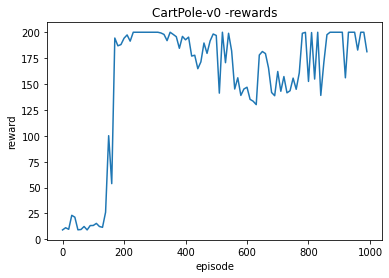

In [23]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_6)
plt.show()

## Double DQN with Prioritized Experience Replay Buffer and Target Network

In [24]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [25]:
replay_buffer = PrioritizedExperienceReplayBuffer(batch_size,size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)

q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_7 = []
timestep = 0
best_value = -1e9
average_last_test = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    
    epsilon = max(epsilon*epsilon_decay,epsilon_min)
    
    state = env.reset()
    
    done = False
    cumul = 0
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() > epsilon :
            action = torch.argmax(q_network(state_t).detach()).item()
        
        else :
            action = env.action_space.sample()
        
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        transition = (state , action , reward , done , new_state)
        
        replay_buffer.add(transition)
        
        # epsilon = np.interp(episode, [0, epsilon_decay], [epsilon_start, epsilon_end])
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0:
            
            
            beta = exponential_annealing_schedule(episode)
            
            idxs, experiences, normalized_weights = replay_buffer.sample(beta)

            _sampling_weights = (torch.as_tensor(normalized_weights, dtype=torch.float32).view((-1, 1)))
            
            states, actions, rewards, dones ,new_states  = (vs for vs in zip(*experiences))

            states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in states]).squeeze()
            actions_t = torch.as_tensor(np.array([a for a in actions]) , dtype=torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(np.array([r for r in rewards]) , dtype=torch.float32).unsqueeze(1)
            dones_t = torch.as_tensor(np.array([o for o in dones] , dtype = int) , dtype=torch.int32).unsqueeze(1)
            new_states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in new_states]).squeeze()
            """
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            rewards = np.asarray([exp[2] for exp in batch],dtype=np.float32)
            dones = np.asarray([exp[3] for exp in batch],dtype=int)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            """
            
            # y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1))
            with torch.no_grad() :
                y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].unsqueeze(1)
            
            td_error = y_target - torch.gather(q_network(states_t),dim=1,index=actions_t)

            replay_buffer.update_priorities(idxs, td_error.abs().cpu().detach().numpy().flatten())
            
            mse = nn.MSELoss() # nn.HuberLoss()
            q_values = torch.gather(q_network(states_t),dim=1,index=actions_t)
            
            loss =  mse(y_target * _sampling_weights,q_values*_sampling_weights)

            # loss = - (torch.gather(q_network(states_t),dim=1,index=actions_t)*_sampling_weights*td_error.detach()).sum()#
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
        timestep += 1
        
        state = new_state
        
    average_last_test.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        
        average = sum(average_last_test) / len(average_last_test)
        if t > best_value :
            print("test new best value : ",t," eps : ",epsilon,"avg : ",average)
            best_value = t
        else :
            print("test : ",t," eps : ",epsilon,"avg :",average)
        list_tests_7.append(t)
        

  0%|▏                                         | 3/1000 [00:00<00:33, 29.95it/s]

test new best value :  9.6  eps :  0.995 avg :  22.0


  1%|▌                                        | 14/1000 [00:00<00:57, 17.07it/s]

test :  9.2  eps :  0.946354579813443 avg : 20.727272727272727


  2%|▉                                        | 22/1000 [00:01<01:16, 12.71it/s]

test new best value :  10.5  eps :  0.9000874278732445 avg :  21.857142857142858


  3%|█▎                                       | 33/1000 [00:02<00:55, 17.46it/s]

test :  9.7  eps :  0.8560822709551227 avg : 19.93548387096774


  4%|█▊                                       | 43/1000 [00:02<01:04, 14.95it/s]

test :  9.6  eps :  0.8142285204175609 avg : 21.146341463414632


  6%|██▎                                      | 55/1000 [00:03<00:54, 17.32it/s]

test :  9.6  eps :  0.7744209942832988 avg : 20.823529411764707


  6%|██▋                                      | 65/1000 [00:04<00:46, 20.11it/s]

test :  8.9  eps :  0.736559652908221 avg : 19.770491803278688


  7%|██▉                                      | 71/1000 [00:04<00:53, 17.30it/s]

test :  9.4  eps :  0.7005493475733617 avg : 19.08450704225352


  8%|███▍                                     | 85/1000 [00:05<00:58, 15.51it/s]

test :  9.8  eps :  0.6662995813682115 avg : 18.85185185185185


  9%|███▊                                     | 92/1000 [00:05<00:53, 16.92it/s]

test new best value :  13.6  eps :  0.6337242817644086 avg :  18.307692307692307


 10%|████                                    | 102/1000 [00:06<00:47, 19.06it/s]

test :  9.9  eps :  0.6027415843082742 avg : 17.95


 11%|████▌                                   | 113/1000 [00:07<01:00, 14.70it/s]

test :  9.2  eps :  0.5732736268885887 avg : 17.77


 12%|████▊                                   | 121/1000 [00:08<01:18, 11.21it/s]

test :  11.9  eps :  0.5452463540625918 avg : 17.14


 13%|█████▎                                  | 132/1000 [00:09<01:07, 12.87it/s]

test :  10.0  eps :  0.5185893309484582 avg : 17.19


 14%|█████▋                                  | 142/1000 [00:09<01:03, 13.56it/s]

test :  11.8  eps :  0.4932355662165453 avg : 16.66


 15%|██████▏                                 | 154/1000 [00:10<00:54, 15.40it/s]

test :  11.3  eps :  0.46912134373457726 avg : 16.61


 16%|██████▍                                 | 162/1000 [00:11<00:58, 14.40it/s]

test :  11.3  eps :  0.446186062443672 avg : 16.87


 17%|██████▉                                 | 172/1000 [00:12<01:12, 11.41it/s]

test new best value :  24.3  eps :  0.42437208406280985 avg :  17.71


 18%|███████▎                                | 182/1000 [00:13<01:26,  9.48it/s]

test new best value :  53.4  eps :  0.4036245882390106 avg :  19.1


 19%|███████▋                                | 192/1000 [00:13<01:04, 12.44it/s]

test new best value :  63.2  eps :  0.38389143477919885 avg :  20.14


 20%|████████                                | 202/1000 [00:15<02:41,  4.93it/s]

test new best value :  147.5  eps :  0.36512303261753626 avg :  23.56


 21%|████████▍                               | 211/1000 [00:18<04:12,  3.13it/s]

test new best value :  200.0  eps :  0.3472722151889232 avg :  28.77


 22%|████████▊                               | 221/1000 [00:22<05:47,  2.24it/s]

test :  143.3  eps :  0.3302941218954743 avg : 37.83


 23%|█████████▏                              | 231/1000 [00:26<04:55,  2.60it/s]

test :  134.4  eps :  0.3141460853680822 avg : 46.59


 24%|█████████▋                              | 241/1000 [00:31<06:30,  1.94it/s]

test :  179.0  eps :  0.2987875242397482 avg : 59.15


 25%|██████████                              | 251/1000 [00:36<06:52,  1.82it/s]

test :  168.7  eps :  0.28417984116121187 avg : 72.26


 26%|██████████▍                             | 261/1000 [00:41<06:15,  1.97it/s]

test :  187.7  eps :  0.2702863258025825 avg : 85.89


 27%|██████████▊                             | 271/1000 [00:46<06:49,  1.78it/s]

test :  184.9  eps :  0.2570720625972084 avg : 99.5


 28%|███████████▏                            | 281/1000 [00:52<07:07,  1.68it/s]

test :  168.0  eps :  0.24450384299593592 avg : 112.73


 29%|███████████▋                            | 291/1000 [00:57<07:28,  1.58it/s]

test :  181.8  eps :  0.23255008201124722 avg : 127.61


 30%|████████████                            | 301/1000 [01:03<06:56,  1.68it/s]

test :  181.4  eps :  0.2211807388415433 avg : 140.05


 31%|████████████▍                           | 311/1000 [01:10<07:43,  1.49it/s]

test :  180.6  eps :  0.21036724137609603 avg : 151.01


 32%|████████████▊                           | 321/1000 [01:16<07:10,  1.58it/s]

test :  185.6  eps :  0.2000824143909432 avg : 157.62


 33%|█████████████▏                          | 331/1000 [01:22<06:51,  1.62it/s]

test :  200.0  eps :  0.1903004112552766 avg : 164.65


 34%|█████████████▋                          | 341/1000 [01:27<06:24,  1.71it/s]

test :  163.0  eps :  0.18099664897669618 avg : 166.5


 35%|██████████████                          | 351/1000 [01:33<06:09,  1.76it/s]

test :  172.1  eps :  0.17214774642209296 avg : 168.05


 36%|██████████████▍                         | 361/1000 [01:39<06:38,  1.60it/s]

test :  177.2  eps :  0.16373146555890544 avg : 169.76


 37%|██████████████▊                         | 371/1000 [01:45<06:13,  1.69it/s]

test :  178.3  eps :  0.1557266555690826 avg : 170.63


 38%|███████████████▏                        | 381/1000 [01:50<05:43,  1.80it/s]

test :  179.8  eps :  0.14811319969530845 avg : 170.01


 39%|███████████████▋                        | 391/1000 [01:57<06:48,  1.49it/s]

test :  182.5  eps :  0.14087196468590776 avg : 170.97


 40%|████████████████                        | 401/1000 [02:03<06:21,  1.57it/s]

test :  171.4  eps :  0.13398475271138335 avg : 171.0


 41%|████████████████▍                       | 411/1000 [02:09<06:24,  1.53it/s]

test :  188.1  eps :  0.12743425563174798 avg : 170.3


 42%|████████████████▊                       | 421/1000 [02:16<06:32,  1.48it/s]

test :  188.6  eps :  0.12120401149972035 avg : 170.46


 43%|█████████████████▏                      | 431/1000 [02:23<06:32,  1.45it/s]

test :  150.5  eps :  0.11527836319047392 avg : 169.9


 44%|█████████████████▋                      | 441/1000 [02:29<06:05,  1.53it/s]

test :  176.3  eps :  0.10964241905397228 avg : 170.98


 45%|██████████████████                      | 451/1000 [02:35<06:08,  1.49it/s]

test :  185.7  eps :  0.1042820154910064 avg : 171.95


 46%|██████████████████▍                     | 461/1000 [02:42<06:12,  1.45it/s]

test :  168.0  eps :  0.09918368135888474 avg : 172.23


 47%|██████████████████▊                     | 471/1000 [02:49<06:13,  1.41it/s]

test :  182.9  eps :  0.0943346041173244 avg : 173.91


 48%|███████████████████▏                    | 481/1000 [02:56<06:16,  1.38it/s]

test :  172.2  eps :  0.08972259762946533 avg : 176.87


 49%|███████████████████▋                    | 491/1000 [03:03<06:06,  1.39it/s]

test :  185.0  eps :  0.08533607153708872 avg : 177.13


 50%|████████████████████                    | 501/1000 [03:10<06:13,  1.34it/s]

test :  175.6  eps :  0.0811640021330769 avg : 178.25


 51%|████████████████████▍                   | 511/1000 [03:17<05:53,  1.38it/s]

test :  197.7  eps :  0.07719590465791494 avg : 179.16


 52%|████████████████████▊                   | 521/1000 [03:24<05:47,  1.38it/s]

test :  198.3  eps :  0.07342180695061275 avg : 179.96


 53%|█████████████████████▏                  | 531/1000 [03:31<05:36,  1.39it/s]

test :  177.5  eps :  0.06983222438783 avg : 180.83


 54%|█████████████████████▋                  | 541/1000 [03:38<05:41,  1.34it/s]

test :  180.2  eps :  0.06641813604822402 avg : 180.92


 55%|██████████████████████                  | 551/1000 [03:48<06:32,  1.14it/s]

test :  186.0  eps :  0.06317096204211972 avg : 182.36


 56%|██████████████████████▍                 | 561/1000 [03:55<05:01,  1.46it/s]

test :  136.7  eps :  0.06008254194952879 avg : 182.72


 57%|██████████████████████▊                 | 571/1000 [04:01<04:51,  1.47it/s]

test :  177.7  eps :  0.05714511431233153 avg : 180.9


 58%|███████████████████████▏                | 581/1000 [04:12<09:16,  1.33s/it]

test :  159.3  eps :  0.0543512971290831 avg : 177.85


 59%|███████████████████████▋                | 591/1000 [04:23<07:32,  1.11s/it]

test :  179.6  eps :  0.05169406930342616 avg : 174.8


 60%|████████████████████████                | 601/1000 [04:32<05:39,  1.18it/s]

test :  143.0  eps :  0.04916675299948831 avg : 171.74


 61%|████████████████████████▍               | 611/1000 [04:39<05:41,  1.14it/s]

test :  167.1  eps :  0.04676299685992172 avg : 168.22


 62%|████████████████████████▊               | 621/1000 [04:46<04:23,  1.44it/s]

test :  135.9  eps :  0.04447676004441063 avg : 163.82


 63%|█████████████████████████▏              | 631/1000 [04:54<05:28,  1.12it/s]

test :  140.1  eps :  0.04230229704853423 avg : 161.09


 64%|█████████████████████████▋              | 641/1000 [05:02<04:49,  1.24it/s]

test :  129.7  eps :  0.04023414326483323 avg : 158.25


 65%|██████████████████████████              | 651/1000 [05:10<04:09,  1.40it/s]

test :  146.8  eps :  0.03826710124979409 avg : 153.49


 66%|██████████████████████████▍             | 661/1000 [05:18<04:28,  1.26it/s]

test :  127.8  eps :  0.036396227662238566 avg : 150.55


 67%|██████████████████████████▊             | 671/1000 [05:27<04:59,  1.10it/s]

test :  129.5  eps :  0.03461682084029365 avg : 148.87


 68%|███████████████████████████▏            | 681/1000 [05:35<04:18,  1.24it/s]

test :  163.0  eps :  0.032924408985721944 avg : 148.62


 69%|███████████████████████████▋            | 691/1000 [05:42<03:58,  1.29it/s]

test :  133.3  eps :  0.03131473892591842 avg : 147.11


 70%|████████████████████████████            | 701/1000 [05:50<03:56,  1.27it/s]

test :  161.7  eps :  0.029783765425331846 avg : 146.55


 71%|████████████████████████████▍           | 711/1000 [05:58<03:55,  1.23it/s]

test :  176.3  eps :  0.02832764101944931 avg : 146.91


 72%|████████████████████████████▊           | 721/1000 [06:07<04:12,  1.11it/s]

test :  152.6  eps :  0.02694270634579598 avg : 149.65


 73%|█████████████████████████████▏          | 731/1000 [06:17<04:23,  1.02it/s]

test :  159.6  eps :  0.02562548094765099 avg : 151.2


 74%|█████████████████████████████▋          | 741/1000 [06:27<04:34,  1.06s/it]

test :  187.2  eps :  0.02437265452736848 avg : 154.24


 75%|██████████████████████████████          | 751/1000 [06:38<04:47,  1.15s/it]

test :  148.8  eps :  0.023181078627322618 avg : 157.32


 76%|██████████████████████████████▍         | 761/1000 [06:51<05:11,  1.31s/it]

test :  181.1  eps :  0.022047758717570132 avg : 162.03


 77%|██████████████████████████████▊         | 771/1000 [07:03<05:08,  1.35s/it]

test :  200.0  eps :  0.020969846670345987 avg : 166.52


 78%|███████████████████████████████▏        | 781/1000 [07:16<05:19,  1.46s/it]

test :  199.9  eps :  0.02 avg : 171.14


 79%|███████████████████████████████▋        | 791/1000 [07:32<05:03,  1.45s/it]

test :  200.0  eps :  0.02 avg : 177.17


 80%|████████████████████████████████        | 801/1000 [07:45<04:19,  1.30s/it]

test :  187.5  eps :  0.02 avg : 182.19


 81%|████████████████████████████████▍       | 811/1000 [07:59<04:41,  1.49s/it]

test :  165.6  eps :  0.02 avg : 186.86


 82%|████████████████████████████████▊       | 821/1000 [08:12<04:02,  1.35s/it]

test :  185.5  eps :  0.02 avg : 190.03


 83%|█████████████████████████████████▏      | 831/1000 [08:25<03:51,  1.37s/it]

test :  200.0  eps :  0.02 avg : 193.38


 84%|█████████████████████████████████▋      | 841/1000 [08:39<03:32,  1.33s/it]

test :  200.0  eps :  0.02 avg : 195.51


 85%|██████████████████████████████████      | 851/1000 [08:53<03:51,  1.55s/it]

test :  199.3  eps :  0.02 avg : 198.13


 86%|██████████████████████████████████▍     | 861/1000 [09:07<03:13,  1.39s/it]

test :  200.0  eps :  0.02 avg : 197.37


 87%|██████████████████████████████████▊     | 871/1000 [09:21<03:08,  1.46s/it]

test :  160.8  eps :  0.02 avg : 196.18


 88%|███████████████████████████████████▏    | 881/1000 [09:36<03:11,  1.61s/it]

test :  164.5  eps :  0.02 avg : 195.96


 89%|███████████████████████████████████▋    | 891/1000 [09:49<02:19,  1.28s/it]

test :  153.9  eps :  0.02 avg : 195.65


 90%|████████████████████████████████████    | 901/1000 [10:01<02:01,  1.22s/it]

test :  197.8  eps :  0.02 avg : 195.54


 91%|████████████████████████████████████▍   | 911/1000 [10:15<02:02,  1.37s/it]

test :  200.0  eps :  0.02 avg : 195.77


 92%|████████████████████████████████████▊   | 921/1000 [10:28<01:36,  1.23s/it]

test :  171.0  eps :  0.02 avg : 195.15


 93%|█████████████████████████████████████▏  | 931/1000 [10:39<01:20,  1.16s/it]

test :  162.7  eps :  0.02 avg : 194.36


 94%|█████████████████████████████████████▋  | 941/1000 [10:51<01:11,  1.21s/it]

test :  198.0  eps :  0.02 avg : 194.39


 95%|██████████████████████████████████████  | 951/1000 [11:04<01:02,  1.27s/it]

test :  142.9  eps :  0.02 avg : 194.03


 96%|██████████████████████████████████████▍ | 961/1000 [11:20<00:58,  1.49s/it]

test :  172.2  eps :  0.02 avg : 194.54


 97%|██████████████████████████████████████▊ | 971/1000 [11:35<00:42,  1.47s/it]

test :  185.7  eps :  0.02 avg : 195.6


 98%|███████████████████████████████████████▏| 981/1000 [11:48<00:26,  1.39s/it]

test :  185.1  eps :  0.02 avg : 195.44


 99%|███████████████████████████████████████▋| 991/1000 [12:00<00:10,  1.20s/it]

test :  151.0  eps :  0.02 avg : 194.04


100%|███████████████████████████████████████| 1000/1000 [12:10<00:00,  1.37it/s]


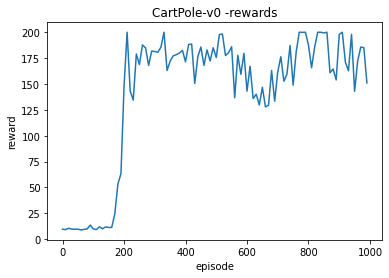

In [26]:
plt.figure()
plt.title("CartPole-v0 -rewards")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_7)
plt.show()

# Summary

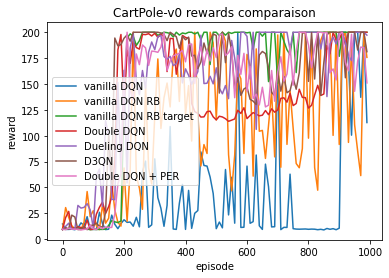

In [27]:
plt.figure()
plt.title("CartPole-v0 rewards comparaison")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_1,label="vanilla DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_2,label="vanilla DQN RB")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_3,label="vanilla DQN RB target")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_4,label="Double DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_5,label="Dueling DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_6,label="D3QN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_7,label="Double DQN + PER")
plt.legend()
plt.show()